### <font color= 'white'> S&P 500 PostCovid *Optimizations & ML models*<font> 

##### [![S&P500-PostCovid_ML](https://img.shields.io/badge/Repository-S&P500--PostCovid--ML-020521?style=flat-square&logo=github&logoColor=white)](https://mango-dune-07a8b7110.1.azurestaticapps.net/?repo=EstebanMqz%2FSP500-Risk-Optimized-Portfolios-PostCovid-ML)

##### <font color= 'lightblue'> *Introduction.* <font>

<font color= 'white'> 
Time series modelling is a powerful forecast tool and the stock market tends to be an interesting example because statistical estimators are of special interest.<br> 
They can be used to predict variables, their interaction with other variables and for efficient decision-making purposes with less human intervention.<br>

- Government
- Banking
- Insurance
- Energy
- Healthcare
- Telecommunications
- Retail
- Education

##### <font color= 'lightblue'> *Objective.* <font>

<font color= 'white'>

In this project, $X_i\in [X_1,X_{500}] \rightarrow S\&P500$ are analyzed and $w_{i=j}$ are optimized for several $X_{P{_{R{max_{j}}}}}$ during Covid until project's present execution date.<br>
The objective of $X_{P{_{R{max_{j}}}}}$ time-series modelling is to make a ML forecast for $X_{P_{{R{max_{j}}}_{(t+1, t+2,..,t+n)}}}$.

It is divided in:<br>

0. Virtual Environment<br>

1. Data Extraction<br>

2. $X_i$ Modelling<br>

3. $X_{P{_{R{max_{j}}}}}$ Optimizations<br>

4. $X_{P{_{R{max_{j}}}}}$ Modelling<br>

5. $X_{P{_{R{max_{j}}}}}$ Forecasting



### <font color= 'lightblue'> 0. Requirements. <font>

##### <font color= 'lightblue'> 0.1 <u> Load Dependencies: </u><font>

In [1]:
import functions as fn
import data as dt
import visualizations as vs 

##### <font color= 'lightblue'> 0.2 <u> Install Libs. & Modules: </u><font>

<span style='color:red'> Project Users: <span>

Create `requirements.txt` file:

<span style='color:gray'> *Skip to `requirements.txt` installation if you are not interested in contributing to the project.* <font>

In [ ]:
docstring = """
# -- -------------------------------------------------------------------------------------- -- # 
# -- project: S&P500-Risk-Optimized-Portfolios-PostCovid-ML                                 -- # 
# -- script: requirements.txt: txt file to download Python modules for execution            -- # 
# -- author: EstebanMqz                                                                     -- # 
# -- license: CC BY 3.0                                                                     -- # 
# -- repository: SP500-Risk-Optimized-Portfolios-PostCovid-ML/blob/main/requirements.txt    -- #                                  
# -- -------------------------------------------------------------------------------------- -- # 
\n
"""

path = fn.get_requirements(docstring)

<span style='color:green'> Project Creators: <span>

Install packages in `requirements.txt` file: <br>

In [ ]:
fn.library_install("requirements.txt")

##### <font color= 'lightblue'> 0.3 <u> Load Libraries & Modules </u><font>

In [2]:
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None
              ,"display.max_colwidth", None, "display.width", None)

import matplotlib
import matplotlib.pyplot as plt
plt.style.use("dark_background")
%matplotlib inline

import scipy
import scipy.stats as st
from scipy import optimize
from scipy.optimize import minimize

import sklearn
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV 
from sklearn import metrics

from yahoofinancials import YahooFinancials 
from tabulate import tabulate
import IPython.display as d
import IPython.core.display

import datetime 
import time

from io import StringIO
from fitter import Fitter, get_common_distributions, get_distributions 
import logging
import ast

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning)

### <font color= 'lightblue'> 1. Data Extraction <font>

<span style='color:white'>

In this section $X_i\in [X_1,X_{500}] \rightarrow S\&P500$ quotes are fetched:

<span style='color:gray'> *Fetching a lot of data from Yahoo Finance by batches is required to avoid host disruptions (other sources could be used).* <font> &nbsp;

In [3]:
tickers=fn.SP500_tickers(50)
tickers[0][0:5], tickers[-1][0:5]

(['MMM', 'AOS', 'ABT', 'ABBV', 'ACN'], ['ZBH', 'ZION', 'ZTS'])

#### <font color= 'lightblue'> 1.1 <u> Fetching Data </u><font> </span>


<span style='color:gray'> *Skip to 1.2 if you prefer using .csv creation date rather than today's date, whatever it is.* <font> &nbsp; 


<span style='color:white'>

$6_Y$ of adj closes from the $S\&P$ $500$ quotes are fetched *(5min)* :<br>

<span style='color:teal'> <u> [*help(dt.get_historical_price_data)*](https://github.com/EstebanMqz/SP500-Risk-Optimized-Portfolios-PostCovid-ML/blob/main/data.py)

In [ ]:
SP_Assets_f = pd.concat([dt.get_historical_price_data(tickers[i][j], 6) 
                         for i in range(0, len(tickers)) for j in range(0, len(tickers[i]))], axis=1)

<span style='color:white'>

$6_Y$ of adj closes for $S\&P$ $500$ fetched :

In [ ]:
SP_f = dt.get_historical_price_data('^GSPC', 6)
SP_f = SP_f[SP_f.index.isin(SP_Assets_f.index)]

<span style='color:white'>

Fetched saved in [*Data*](https://github.com/EstebanMqz/SP500-Risk-Optimized-Portfolios-PostCovid-ML/tree/main/Data) *subdirectory*:<br>
+ `Assets_SP500.csv`
+ `SP500_index.csv`

In [ ]:
SP_Assets_f.to_csv("Data/Assets_SP500.csv")   
SP_f.to_csv("Data/SP500.csv")

<span style='color:white'>

Display data:

In [ ]:
SP_Assets_f.head(8)

In [ ]:
SP_Assets_f.tail(8)

#### <font color= 'lightblue'> 1.2 <u> Reading data </u><font> </span>

<span style='color:white'>

To pair observations [`pd.isin`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isin.html) method is applied *(2 rows dropped)*:

In [7]:
SP_r = pd.read_csv("Data/SP500.csv", index_col=0)
SP_Assets_r = pd.read_csv("Data/Assets_SP500.csv", index_col=0)
SP_r.shape, SP_Assets_r.shape

((1509, 1), (1509, 503))

<span style='color:white'>

$X_i$ is described to get a better understanding of the data sets involved in optimization subsets $X_{P{_{R{max_{j}}}}} \& X_{P{_{R{max}}}}$.

### <font color= 'lightblue'> 
### 2. $X_i$ Modelling </span>

<span style='color:white'>

If data sets $X_{i=j}$ are analyzed, then $w_{i}$ can be included from $X_i$, and $w_{i=j}$ discarded or adjusted from $X_{P{_{R{max_{j}}}}}$ optimizations, <br>
rather than limiting to the preestablished conditions imposed by the objective functions and their constraints if it is more feasible.

For future references, fitted parameters estimators $f(\hat{X_i})$ will be obtained and their relative qualities assesed to complement this section.

<span style='color:white'>

It is known, Log returns are used because of their additive properties and Continuous Compounding effects.<br>

Whereas Simple Returns are used for their multiplicative properties and Discrete Compounding effects.<br>

To describe and model $X_i$, $X_{P{_{R{max_{j}}}}}$ and $X_{P{_{R{max}}}}$ assumptions are verified with data.

##### <font color= 'lightblue'> 2.1 <u> Quantitative Experimental Research </u><font> </span>

$R_{{t,t+1}}$ $\&$ $Ln(r_{{t,t+1}})$ vs $R_{{t_{n}}}$ $\&$ $Ln(r_{{t_{n}}})$ 

<span style='color:white'>

<div class="alert alert-block alert-info">

Given a random returns:<br>

$n=1,2$<br>

*e.g. $R_{t_{1,2}}$ $\&$ $Ln{(r_{t_{1,2}})}$* :

<font size="1">

$R_{t_{1,2}} = [(1 + .05)(1 - .045)] - 1 \approx 0.00275$<br>

$Ln{(r_{t_{1,2}})} = ln(1+0.05) + ln(1-0.045) \approx .002746$<br>

</font>

$R_{t_{1,2}} \approx Ln{(r_{t_{1,2}})}$<br>

$$ R_{t_{n}} = \prod_{i=1}^{n} (1 + R_{t{_i}}) -1 $$
$$ Ln(r_{t_{n}}) = \sum_{i=1}^{n} ln(1 + r_{t{_i}}) $$

In [8]:
((1+0.05)*(1-0.045)) - 1 , np.log(1+0.05) + np.log(1-0.045)

(0.00275000000000003, 0.0027462256680251956)

<div class="alert alert-block alert-info">

Nevertheless, if $t \to \infty$: 

$$\lim_{n \to \infty} R_{t} = \lim_{n \to \infty} \prod_{i=1}^{n} (1 + R_{t{_i}}) - \lim_{n \to \infty} 1$$

by the limits property of a constant: $$\lim_{n \to \infty} R_{t} = \bigg[\lim_{n \to \infty} \prod_{i=1}^{n} (1 + R_{t{_i}}) - 1\bigg]$$<br>

while $\lim_{n \to \infty} r_{t}$ is:

$$\lim_{n \to \infty} r_{t} = \lim_{n \to \infty} \sum_{i=1}^{n} ln(1 + r_{t{_i}})$$

therefore $\lim_{n \to \infty} R_{t} \pm \lim_{n \to \infty} r_{t}$:<br>

$$\lim_{n \to \infty} \bigg[\prod_{i=1}^{n} (1 + r_{t{_i}}) \pm \sum_{i=1}^{n} ln(1 + R_{t{_i}}) \bigg] = \pm 1$$

<span style='color:white'>

*Accumulated returns are calculated as follows*:

<span style='color:white'>

To make the Machine Learning model for $f(\hat{X_i})$ from $X_{P{_{R{max_{j}}}}}$ with $R_{t}$ or $Ln_{R_{t{_i}}}$ while avoiding a bias for $\mu(t_i)$ and $\sigma(t_i)$ estimations,<br>
key assumptions from nature of the random variables are verified so *Maximum Likelihood Estimators* can be modelled with the right params.<br>

*Probability Density Functions* in [Fitter](https://github.com/cokelaer/fitter) module: 

In [23]:
continuous = [d for d in dir(st) if isinstance(getattr(st, d), getattr(st, "rv_continuous"))]
discrete = [d for d in dir(st) if isinstance(getattr(st, d), getattr(st, "rv_discrete"))]
pd.DataFrame(continuous).rename(index={0:"Continuous"}).T

,Continuous,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103
0,alpha,anglit,arcsine,argus,beta,betaprime,bradford,burr,burr12,cauchy,chi,chi2,cosine,crystalball,dgamma,dweibull,erlang,expon,exponnorm,exponpow,exponweib,f,fatiguelife,fisk,foldcauchy,foldnorm,gamma,gausshyper,genexpon,genextreme,gengamma,genhalflogistic,genhyperbolic,geninvgauss,genlogistic,gennorm,genpareto,gilbrat,gompertz,gumbel_l,gumbel_r,halfcauchy,halfgennorm,halflogistic,halfnorm,hypsecant,invgamma,invgauss,invweibull,johnsonsb,johnsonsu,kappa3,kappa4,ksone,kstwo,kstwobign,laplace,laplace_asymmetric,levy,levy_l,levy_stable,loggamma,logistic,loglaplace,lognorm,loguniform,lomax,maxwell,mielke,moyal,nakagami,ncf,nct,ncx2,norm,norminvgauss,pareto,pearson3,powerlaw,powerlognorm,powernorm,rayleigh,rdist,recipinvgauss,reciprocal,rice,semicircular,skewcauchy,skewnorm,studentized_range,t,trapezoid,trapz,triang,truncexpon,truncnorm,tukeylambda,uniform,vonmises,vonmises_line,wald,weibull_max,weibull_min,wrapcauchy


In [24]:
pd.DataFrame(discrete[:]).T.rename(index={0:"Discrete"})

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
Discrete,bernoulli,betabinom,binom,boltzmann,dlaplace,geom,hypergeom,logser,nbinom,nchypergeom_fisher,nchypergeom_wallenius,nhypergeom,planck,poisson,randint,skellam,yulesimon,zipf,zipfian


In [25]:
rf, best, r_jump, start, execution_date = .00169, 25, 0.05, "2020-03-02", SP_Assets_r.tail(1).index[0]

<span style='color:white'>

$\forall X_i \in [X_1,X_{500}]$ :<br>

$R_{{t,t+1}}$ $\&$ $Ln(r_{{t,t+1}})$ is compared to $R_{t_{n}}$ $\&$ $Ln(r_{t_{n}})$: <br>

<u> [*help(vs.selection_data)*](https://github.com/EstebanMqz/SP500-Risk-Optimized-Portfolios-PostCovid-ML/blob/main/visualizations.py)

##### <font color= 'lightblue'> 
2.1.2 $R_{{t,t+1}}$ $\&$ $Ln(r_{{t,t+1}})$

<span style='color:white'>

$R_{{t,t+1}}$ for $X_i$ are the following:

In [26]:
rf, best, r_jump, start, execution_date = .00169, 25, 0.05, "2020-03-02", SP_Assets_r.tail(1).index[0]
prices, summary_simple, r_simple = vs.selection_data(SP_Assets_r, "Simple", rf, best, start, execution_date)
r_simple.tail()

,MMM,AOS,ABT,ABBV,ACN,ATVI,ADM,ADBE,ADP,AAP,AES,AFL,A,APD,AKAM,ALK,ALB,ARE,ALGN,ALLE,LNT,ALL,GOOGL,GOOG,MO,AMZN,AMCR,AMD,AEE,AAL,AEP,AXP,AIG,AMT,AWK,AMP,ABC,AME,AMGN,APH,ADI,ANSS,AON,APA,AAPL,AMAT,APTV,ACGL,ANET,AJG,AIZ,T,ATO,ADSK,AZO,AVB,AVY,AXON,BKR,BALL,BAC,BBWI,BAX,BDX,WRB,BRK-B,BBY,BIO,TECH,BIIB,BLK,BK,BA,BKNG,BWA,BXP,BSX,BMY,AVGO,BR,BRO,BF-B,BG,CHRW,CDNS,CZR,CPT,CPB,COF,CAH,KMX,CCL,CTLT,CAT,CBOE,CBRE,CDW,CE,CNC,CNP,CDAY,CF,CRL,SCHW,CHTR,CVX,CMG,CB,CHD,CI,CINF,CTAS,CSCO,C,CFG,CLX,CME,CMS,KO,CTSH,CL,CMCSA,CMA,CAG,COP,ED,STZ,COO,CPRT,GLW,CTVA,CSGP,COST,CTRA,CCI,CSX,CMI,CVS,DHI,DHR,DRI,DVA,DE,DAL,XRAY,DVN,DXCM,FANG,DLR,DFS,DISH,DIS,DG,DLTR,D,DPZ,DOV,DOW,DTE,DUK,DD,DXC,EMN,ETN,EBAY,ECL,EIX,EW,EA,ELV,LLY,EMR,ENPH,ETR,EOG,EPAM,EQT,EFX,EQIX,EQR,ESS,EL,ETSY,RE,EVRG,ES,EXC,EXPE,EXPD,EXR,XOM,FFIV,FDS,FICO,FAST,FRT,FDX,FITB,FSLR,FE,FIS,FISV,FLT,FMC,F,FTNT,FTV,FOXA,FOX,BEN,FCX,GRMN,IT,GEN,GNRC,GD,GE,GIS,GM,GPC,GILD,GL,GPN,GS,HAL,HIG,HAS,HCA,PEAK,HSIC,HSY,HES,HPE,HLT,HOLX,HD,HON,HRL,HST,HWM,HPQ,HUM,HBAN,HII,IBM,IEX,IDXX,ITW,ILMN,INCY,IR,PODD,INTC,ICE,IFF,IP,IPG,INTU,ISRG,IVZ,INVH,IQV,IRM,JBHT,JKHY,J,JNJ,JCI,JPM,JNPR,K,KDP,KEY,KEYS,KMB,KIM,KMI,KLAC,KHC,KR,LHX,LH,LRCX,LW,LVS,LDOS,LEN,LNC,LIN,LYV,LKQ,LMT,L,LOW,LYB,MTB,MRO,MPC,MKTX,MAR,MMC,MLM,MAS,MA,MTCH,MKC,MCD,MCK,MDT,MRK,META,MET,MTD,MGM,MCHP,MU,MSFT,MAA,MRNA,MHK,MOH,TAP,MDLZ,MPWR,MNST,MCO,MS,MOS,MSI,MSCI,NDAQ,NTAP,NFLX,NWL,NEM,NWSA,NWS,NEE,NKE,NI,NDSN,NSC,NTRS,NOC,NCLH,NRG,NUE,NVDA,NVR,NXPI,ORLY,OXY,ODFL,OMC,ON,OKE,ORCL,PCAR,PKG,PARA,PH,PAYX,PAYC,PYPL,PNR,PEP,PFE,PCG,PM,PSX,PNW,PXD,PNC,POOL,PPG,PPL,PFG,PG,PGR,PLD,PRU,PEG,PTC,PSA,PHM,QRVO,PWR,QCOM,DGX,RL,RJF,RTX,O,REG,REGN,RF,RSG,RMD,RVTY,RHI,ROK,ROL,ROP,ROST,RCL,SPGI,CRM,SBAC,SLB,STX,SEE,SRE,NOW,SHW,SPG,SWKS,SJM,SNA,SEDG,SO,LUV,SWK,SBUX,STT,STLD,STE,SYK,SYF,SNPS,SYY,TMUS,TROW,TTWO,TPR,TRGP,TGT,TEL,TDY,TFX,TER,TSLA,TXN,TXT,TMO,TJX,TSCO,TT,TDG,TRV,TRMB,TFC,TYL,TSN,USB,UDR,ULTA,UNP,UAL,UPS,URI,UNH,UHS,VLO,VTR,VRSN,VRSK,VZ,VRTX,VFC,VTRS,VICI,V,VMC,WAB,WBA,WMT,WBD,WM,WAT,WEC,WFC,WELL,WST,WDC,WRK,WY,WHR,WMB,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
formatted_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-05-10,0.000992,-0.001443,0.003991,-0.002792,0.020533,0.006489,-0.005065,0.003998,0.006318,0.002231,0.016614,-0.010383,0.005575,0.003608,0.084432,-0.017995,-0.003382,0.008661,0.008324,0.004265,0.013971,-0.006333,0.040987,0.040207,-0.010767,0.033483,0.007759,0.020619,0.010806,-0.008984,0.006806,-0.030643,-0.009228,0.014675,0.012578,-0.008961,0.007429,0.001870,-0.001365,0.003591,0.010077,0.007356,-0.003464,-0.010856,0.010421,0.013791,0.016494,0.007962,0.019636,0.005739,-0.010416,0.001175,0.006835,0.018627,0.002619,0.004629,0.013989,-0.150520,-0.010642,-0.007014,-0.012292,-0.012717,0.017642,0.005608,0.000679,-0.005787,-0.005919,-0.003189,0.001480,-0.002357,-0.010054,-0.012518,-0.005152,0.004179,-0.004493,-0.007452,0.002449,0.007206,0.012546,0.015077,0.000305,0.006740,0.003247,-0.009154,0.000784,-0.016733,0.000181,-0.004579,-0.022132,0.009840,0.012133,-0.015023,-0.041381,-0.001499,0.017566,0.005860,0.005365,-0.015401,-0.011239,0.002317,0.012282,0.000000,-0.006294,-0.008135,0.002773,-0.012758,0.010912,-0.005013,0.002814,0.002512,-0.009666,0.024895,0.005165,-0.003224,-0.024952,0.002379,0.003683,0.010950,0.001735,0.015090,0.005704,0.006058,-0.034445,-0.028035,-0.010440,0.006480,0.003238,0.014560,0.006289,0.004172,0.008231,0.019595,-0.002256,-0.015298,0.016232,-0.006558,-0.024837,-0.003716,-0.002019,-0.007357,-0.008448,-0.014396,-0.002753,-0.011696,0.002688,-0.021558,0.024404,-0.012038,0.023393,

<span style='color:white'>

$Ln(r_{{t,t+1}})$ for $X_i$ are the following:

In [27]:
prices, summary_log, r_log = vs.selection_data(SP_Assets_r, "Log", rf, best, start, execution_date)[:]
r_log.tail()

,MMM,AOS,ABT,ABBV,ACN,ATVI,ADM,ADBE,ADP,AAP,AES,AFL,A,APD,AKAM,ALK,ALB,ARE,ALGN,ALLE,LNT,ALL,GOOGL,GOOG,MO,AMZN,AMCR,AMD,AEE,AAL,AEP,AXP,AIG,AMT,AWK,AMP,ABC,AME,AMGN,APH,ADI,ANSS,AON,APA,AAPL,AMAT,APTV,ACGL,ANET,AJG,AIZ,T,ATO,ADSK,AZO,AVB,AVY,AXON,BKR,BALL,BAC,BBWI,BAX,BDX,WRB,BRK-B,BBY,BIO,TECH,BIIB,BLK,BK,BA,BKNG,BWA,BXP,BSX,BMY,AVGO,BR,BRO,BF-B,BG,CHRW,CDNS,CZR,CPT,CPB,COF,CAH,KMX,CCL,CTLT,CAT,CBOE,CBRE,CDW,CE,CNC,CNP,CDAY,CF,CRL,SCHW,CHTR,CVX,CMG,CB,CHD,CI,CINF,CTAS,CSCO,C,CFG,CLX,CME,CMS,KO,CTSH,CL,CMCSA,CMA,CAG,COP,ED,STZ,COO,CPRT,GLW,CTVA,CSGP,COST,CTRA,CCI,CSX,CMI,CVS,DHI,DHR,DRI,DVA,DE,DAL,XRAY,DVN,DXCM,FANG,DLR,DFS,DISH,DIS,DG,DLTR,D,DPZ,DOV,DOW,DTE,DUK,DD,DXC,EMN,ETN,EBAY,ECL,EIX,EW,EA,ELV,LLY,EMR,ENPH,ETR,EOG,EPAM,EQT,EFX,EQIX,EQR,ESS,EL,ETSY,RE,EVRG,ES,EXC,EXPE,EXPD,EXR,XOM,FFIV,FDS,FICO,FAST,FRT,FDX,FITB,FSLR,FE,FIS,FISV,FLT,FMC,F,FTNT,FTV,FOXA,FOX,BEN,FCX,GRMN,IT,GEN,GNRC,GD,GE,GIS,GM,GPC,GILD,GL,GPN,GS,HAL,HIG,HAS,HCA,PEAK,HSIC,HSY,HES,HPE,HLT,HOLX,HD,HON,HRL,HST,HWM,HPQ,HUM,HBAN,HII,IBM,IEX,IDXX,ITW,ILMN,INCY,IR,PODD,INTC,ICE,IFF,IP,IPG,INTU,ISRG,IVZ,INVH,IQV,IRM,JBHT,JKHY,J,JNJ,JCI,JPM,JNPR,K,KDP,KEY,KEYS,KMB,KIM,KMI,KLAC,KHC,KR,LHX,LH,LRCX,LW,LVS,LDOS,LEN,LNC,LIN,LYV,LKQ,LMT,L,LOW,LYB,MTB,MRO,MPC,MKTX,MAR,MMC,MLM,MAS,MA,MTCH,MKC,MCD,MCK,MDT,MRK,META,MET,MTD,MGM,MCHP,MU,MSFT,MAA,MRNA,MHK,MOH,TAP,MDLZ,MPWR,MNST,MCO,MS,MOS,MSI,MSCI,NDAQ,NTAP,NFLX,NWL,NEM,NWSA,NWS,NEE,NKE,NI,NDSN,NSC,NTRS,NOC,NCLH,NRG,NUE,NVDA,NVR,NXPI,ORLY,OXY,ODFL,OMC,ON,OKE,ORCL,PCAR,PKG,PARA,PH,PAYX,PAYC,PYPL,PNR,PEP,PFE,PCG,PM,PSX,PNW,PXD,PNC,POOL,PPG,PPL,PFG,PG,PGR,PLD,PRU,PEG,PTC,PSA,PHM,QRVO,PWR,QCOM,DGX,RL,RJF,RTX,O,REG,REGN,RF,RSG,RMD,RVTY,RHI,ROK,ROL,ROP,ROST,RCL,SPGI,CRM,SBAC,SLB,STX,SEE,SRE,NOW,SHW,SPG,SWKS,SJM,SNA,SEDG,SO,LUV,SWK,SBUX,STT,STLD,STE,SYK,SYF,SNPS,SYY,TMUS,TROW,TTWO,TPR,TRGP,TGT,TEL,TDY,TFX,TER,TSLA,TXN,TXT,TMO,TJX,TSCO,TT,TDG,TRV,TRMB,TFC,TYL,TSN,USB,UDR,ULTA,UNP,UAL,UPS,URI,UNH,UHS,VLO,VTR,VRSN,VRSK,VZ,VRTX,VFC,VTRS,VICI,V,VMC,WAB,WBA,WMT,WBD,WM,WAT,WEC,WFC,WELL,WST,WDC,WRK,WY,WHR,WMB,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
formatted_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-05-10,0.000992,-0.001444,0.003983,-0.002796,0.020325,0.006468,-0.005078,0.003990,0.006299,0.002228,0.016478,-0.010437,0.005560,0.003601,0.081056,-0.018159,-0.003387,0.008624,0.008290,0.004256,0.013874,-0.006354,0.040170,0.039420,-0.010825,0.032935,0.007729,0.020409,0.010748,-0.009025,0.006783,-0.031122,-0.009271,0.014569,0.012499,-0.009002,0.007402,0.001868,-0.001366,0.003584,0.010026,0.007329,-0.003470,-0.010916,0.010367,0.013697,0.016359,0.007931,0.019446,0.005722,-0.010470,0.001174,0.006812,0.018456,0.002615,0.004618,0.013892,-0.163131,-0.010699,-0.007039,-0.012368,-0.012799,0.017488,0.005592,0.000678,-0.005804,-0.005936,-0.003194,0.001479,-0.002359,-0.010105,-0.012597,-0.005165,0.004170,-0.004503,-0.007480,0.002446,0.007180,0.012468,0.014965,0.000305,0.006717,0.003242,-0.009197,0.000784,-0.016874,0.000181,-0.004589,-0.022381,0.009792,0.012060,-0.015137,-0.042262,-0.001500,0.017413,0.005843,0.005351,-0.015521,-0.011303,0.002314,0.012207,0.000000,-0.006314,-0.008168,0.002769,-0.012840,0.010853,-0.005025,0.002810,0.002508,-0.009713,0.024590,0.005151,-0.003230,-0.025269,0.002376,0.003676,0.010890,0.001734,0.014977,0.005688,0.006039,-0.035052,-0.028435,-0.010495,0.006459,0.003233,0.014455,0.006270,0.004163,0.008198,0.019405,-0.002259,-0.015416,0.016102,-0.006580,-0.025151,-0.003723,-0.002021,-0.007384,-0.008484,-0.014501,-0.002756,-0.011765,0.002685,-0.021794,0.024111,-0.012111,0.023124,

The change is modelled as follows: 

0.0003424623180847394

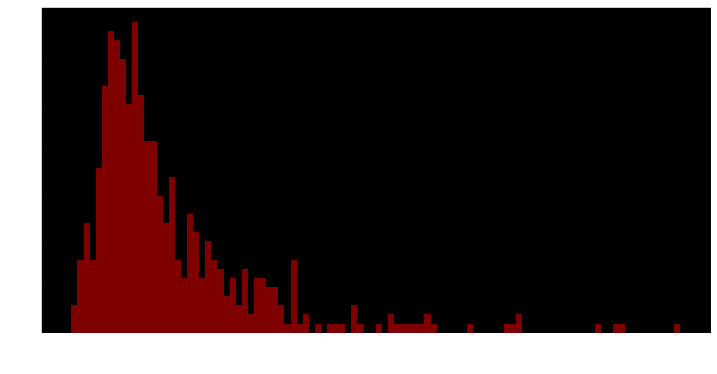

In [41]:
t_t1 = abs(r_simple.mean() - r_log.mean())
t_t1.plot(kind="hist", bins=100, figsize=(12,6), color="red", alpha=0.5, label="t_t1", density=False)
plt.xlabel("$\mu_{\Delta r_{t, t+1}}$"), plt.ylabel("Companies")
t_t1.mean()

<span style='color:white'>

$\mu_i\bigg[R_{{t,t+1}}$ $\pm$ $Ln(r_{{t,t+1}})\bigg]$ $\forall X_i\in [X_1,X_{500}]$ is:

In [ ]:
(t_t1).mean(axis=1)[0]

<span style='color:white'>

So $R_{{t,t+1}}$ $\approx$ $Ln(r_{{t,t+1}})$


##### <font color= 'lightblue'> 
2.1.2 $R_{{t_{n}}}$ $\&$ $Ln(r_{{t_{n}}})$

In [ ]:
r_simple.cumsum().tail()

<span style='color:white'>

Whereas, much bigger differences are present in data for Accumulated $R_{t}$ $\&$ $Ln(r_{t})$ .

In [ ]:
r_log.cumsum().tail()

<div class="alert alert-block alert-info">

The difference: $$ \frac{\mu Ln(r_{t_{n}})}{\mu R_{t_{n}}}-1$$ <br>
Is the following for $X_i \in [X_1,X_{500}]$ in the $S\&P$ $500$ from $2020-03-02$ to execution's day:

In [ ]:
(((( r_log.cumsum().tail(1) / r_simple.cumsum().tail(1)) - 1)).sum().sum() / r_simple.shape[1])

<span style='color:white'>

to evaluate their differences in $t_{1,2,..,n}$

##### Ratios :
Using $R_{t_{n}}$ $\&$ $Ln(r_{t_{n}})$, the following Ratios as well as $\mu(t_n)$ and $\sigma(t_n)$ are compared for the selection $X_i\in [X_1,X_{500}]$.

<div class="alert alert-block alert-info">

Sharpe's Ratio measures the units of risk *($\small \sigma$)* per unit of excess returns over a risk-free rate *($\small rf$)* :
+ $R_{Sharpe} = \frac{\mu_i - {rf}}{\sigma_i(r_t)}$.
<br>

Sortino's Ratio measures the units of negative risks *[$\sigma_{i}\small(r_{t\leq 0})$]* per unit of excess returns over a risk-free rate *($\small rf$)* :
+ $R_{Sortino} = \frac{\mu_i - {rf}}{\sigma_{i}(r_{t\leq 0})}$ 

To avoid risks associated to negative returns, Data Selection $\forall X_i\in [X_1,X_{500}] \rightarrow X_{P{_{R{max}}}}$ is based on $S\&P500$ *Sortino's Ratio Top 25*:

In [ ]:
rf, best, r_jump = .00169, 25, 0.05
start, execution_date = "2020-03-02", SP_Assets_r.tail(1).index[0]

simple_selection, simple_summary, simple_r = vs.selection_data(SP_Assets_r, 'Simple', rf, best, start, execution_date)
log_selection, log_summary, log_r = vs.selection_data(SP_Assets_r, 'Log', rf, best, start, execution_date)

Selection using *Sortino's Ratio top 25:*

<div class="alert alert-block alert-info">

With $R_{t}$ $\&$ $Ln(r_{t})$, Ratios and Estimator Parameters $\mu(t_n)$ and $\sigma(t_n)$ $\forall X_i\in [X_1,X_{500}]$ are different and so is the selection for $X_{P{_{R{max_{j}}}}}$. <br>

In [ ]:
fn.retSLog_Selection(SP_Assets_r, rf, best, start, execution_date)


In [ ]:
vs.Selection_R_SLog_Plot(SP_Assets_r, rf, best, start, execution_date, r_jump)

##### <font color= 'lightblue'> 2.2 <u> Modelling $X_i$ <u> <font>

In [ ]:
def Stats(dataframe, Selection, r, P, percentiles, dist, title, color):
    """
    Stats is a function that resamples data from a Selection performed over a dataframe.
    Parameters:
    ----------
    dataframe : dataframe
        Dataframe from which the Selection is made, in order to acess Selection's original data.
    Selection : list
        Selection to Resample for given period(s) etc. basis whose period is longer than original data.
    r : str
        Type of return for the model: "Simple" (multiplicative) or "Log" (additive).
    P : str
        Period of Resample (e.g. "W" for Weekly, "M" for Monthly, "3T" for Trimestral, "Q" for Quarterly,
        "Y" for Yearly, etc. for Dataframe.resample (see refs.).
    percentiles : list
        List of Returns of Percentiles returned by vs.Stats[0] dataframe (e.g. [.05, .25, .5, .75, .95]).
    dist : list
        Continuous Distributions to fit on datasets Xi
    title : str
        Title of the Box-plot
    color : str
        Color of the Box-plot.
    Returns:
    -------
    describe : dataframe
        Stats returns summary statistics (mean, std, min, max, percentiles, skewness and kurtosis) in a 
        markdown object callable as a dataframe by assigning a variable to the function in pos. [2].  
    """
    
    if  r == "Simple" :
        Selection = (dataframe[Selection.index].pct_change()).iloc[1:, :].dropna(axis = 1)
    if  r == "Log" :
        Selection = np.log(dataframe[Selection.index]).diff().iloc[1:, :].dropna(axis = 1)
    if r != "Simple" and r != "Log" :
        print("Aborted: Please select a valid Return type: 'Simple' or 'Log'. Stats help command: help(vs.Stats)")
    
    Selection.index = pd.to_datetime(Selection.index)
    Selection_Mo_r = Selection.resample(P).agg(lambda x: x[-1])
    Selection_Mo_r.plot(kind = "box", figsize = (22, 13), title = title, color = color, fontsize = 13)
    
    for i in range(0, len(Selection_Mo_r.columns)):
        plt.text(x = i + 0.96 , y = Selection_Mo_r.iloc[:, i].mean() + .0075, s = str("$\mu$ = +") + str(round(Selection_Mo_r.iloc[:, i].mean(), 4)), fontsize = 6.5, fontweight = "bold", color = "lightgreen")
        plt.text(x = i + 0.98 , y = Selection_Mo_r.iloc[:, i].max() + .010, s = str("+") + str(round(Selection_Mo_r.iloc[:, i].max(), 3)), fontsize = 8.5, color = "green")
        plt.text(x = i + 0.98 , y = Selection_Mo_r.iloc[:, i].min() - .015, s = str(round(Selection_Mo_r.iloc[:, i].min(), 3)), fontsize = 8.5, color = "red")

    describe = Selection_Mo_r.describe(percentiles)
    describe["mode"] = Selection_Mo_r.mode().iloc[0, :]
    describe["skewness"] = st.skew(Selection_Mo_r)
    describe["kurtosis"] = st.kurtosis(Selection_Mo_r)
    describe.replace("\n", "")

    dist_fit = np.empty(len(Selection_Mo_r.columns), dtype=object)
    
    for i in range(0, len(Selection.columns)):
        f = Fitter(pd.DataFrame(Selection_Mo_r.iloc[:, i]), distributions = dist, timeout=5)
        f.fit()
        params, AIC, BIC = [StringIO() for i in range(3)]
        (print(f.get_best(), file=params)), (print(f.get_best(method="aic"), file=AIC)), (print(f.get_best(method="bic"), file=BIC))
        params, AIC, BIC = [i.getvalue() for i in [params, AIC, BIC]]
        dist_fit[i] = (params + AIC + BIC).replace("\n", ", ")
    
    plt.title(title, fontsize = 20)
    plt.axhline(0, color = "red", lw = .5, linestyle = "--")
    plt.axhspan(0, Selection_Mo_r.min().min(), facecolor = "red", alpha = 0.2) 
    plt.axhspan(0, Selection_Mo_r.max().max(), facecolor = "green", alpha = 0.2)

    plt.xticks(rotation = 45)
    for i, t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if (i % 2) != 0:
            t.set_color("lightgreen")
        else:
            t.set_color("white")
            
    plt.yticks(np.arange(round(Selection_Mo_r.min().min(), 1), round(Selection_Mo_r.max().max(), 1), 0.05))
    plt.grid(alpha = 0.5, linestyle = "--", color = "grey")
    IPython.core.display.clear_output() 
    return describe, dist_fit, plt.show()

In [ ]:
Sortino25[2]

In [ ]:
Selection.tail()

In [ ]:
(SP_Assets_r.loc[start:today][Sortino25[2].index]).pct_change().iloc[1:, :].dropna(axis = 1).tail()

In [ ]:
np.log(SP_Assets_r.loc[start:today][Sortino25[2].index]).diff().iloc[1:, :].dropna(axis = 1).tail()

In [ ]:
SP_Assets_r.loc[start:today], Sortino25[2]

In [ ]:
dist=([d for d in dir(st) if isinstance(getattr(st, d), getattr(st, "rv_continuous"))])[0:60]

def ret(dataframe, selection, r):
    if  r == "Simple" :
        returns = (dataframe[selection.index]).pct_change().iloc[1:, :].dropna(axis = 1)
    if  r == "Log" :
        returns = np.log(dataframe[selection.index]).diff().iloc[1:, :].dropna(axis = 1)   
    if r != "Simple" and r != "Log" :
        print("Aborted: Please select a valid Return type: 'Simple' or 'Log'. selection_data help command: help(vs.selection_data)")
    
    returns.index = pd.to_datetime(returns.index)
    returns_Mo_r = returns.resample("M").agg(lambda x: x[-1])
    returns_Mo_r.plot(kind = "box", figsize = (22, 13), title = "test", color = "yellow", fontsize = 13)

    return returns, returns_Mo_r.max()

ret(SP_Assets_r.loc[start:today], Sortino25[2], "Simple")[1]


#Selection.index = pd.to_datetime(Sortino25[2].index)
# Selection_Mo_r = Selection.resample(P).agg(lambda x: x[-1])
# Selection_Mo_r.plot(kind = "box", figsize = (22, 13), title = title, color = color, fontsize = 13)

# for i in range(0, len(Selection_Mo_r.columns)):
#     plt.text(x = i + 0.96 , y = Selection_Mo_r.iloc[:, i].mean() + .0075, s = str("$\mu$ = +") + str(round(Selection_Mo_r.iloc[:, i].mean(), 4)), fontsize = 6.5, fontweight = "bold", color = "lightgreen")
#     plt.text(x = i + 0.98 , y = Selection_Mo_r.iloc[:, i].max() + .010, s = str("+") + str(round(Selection_Mo_r.iloc[:, i].max(), 3)), fontsize = 8.5, color = "green")
#     plt.text(x = i + 0.98 , y = Selection_Mo_r.iloc[:, i].min() - .015, s = str(round(Selection_Mo_r.iloc[:, i].min(), 3)), fontsize = 8.5, color = "red")

# describe = Selection_Mo_r.describe(percentiles)
# describe["mode"] = Selection_Mo_r.mode().iloc[0, :]
# describe["skewness"] = st.skew(Selection_Mo_r)
# describe["kurtosis"] = st.kurtosis(Selection_Mo_r)
# describe.replace("\n", "")

# dist_fit = np.empty(len(Selection_Mo_r.columns), dtype=object)

# for i in range(0, len(Selection.columns)):
#     f = Fitter(pd.DataFrame(Selection_Mo_r.iloc[:, i]), distributions = dist, timeout=5)
#     f.fit()
#     params, AIC, BIC = [StringIO() for i in range(3)]
#     (print(f.get_best(), file=params)), (print(f.get_best(method="aic"), file=AIC)), (print(f.get_best(method="bic"), file=BIC))
#     params, AIC, BIC = [i.getvalue() for i in [params, AIC, BIC]]
#     dist_fit[i] = (params + AIC + BIC).replace("\n", ", ")

# plt.title(title, fontsize = 20)
# plt.axhline(0, color = "red", lw = .5, linestyle = "--")
# plt.axhspan(0, Selection_Mo_r.min().min(), facecolor = "red", alpha = 0.2) 
# plt.axhspan(0, Selection_Mo_r.max().max(), facecolor = "green", alpha = 0.2)

# plt.xticks(rotation = 45)
# for i, t in enumerate(plt.gca().xaxis.get_ticklabels()):
#     if (i % 2) != 0:
#         t.set_color("lightgreen")
#     else:
#         t.set_color("white")
        
# plt.yticks(np.arange(round(Selection_Mo_r.min().min(), 1), round(Selection_Mo_r.max().max(), 1), 0.05))
# plt.grid(alpha = 0.5, linestyle = "--", color = "grey")
# plt.show()

$r_{Log}(X_i)$

In [ ]:
Selection = np.log(dataframe[Selection.index]).diff().iloc[1:, :].dropna(axis = 1)

In [ ]:
#Stats(dataframe, Selection, r, P, percentiles, dist, title, color):
describe_Wk = Stats(SP_Assets_r.loc[start:today], Sortino25[2], "Log", "W", [.025, .25, .5, .75, .95], dist, 
                    "$S&P$ 500 $r_{Log}(X_i)$ Selection Weekly Resampling from" + str(start) + "to" + str(today), "lightyellow")

In [ ]:
describe_Wk[0]

In [ ]:
describe_Mo = vs.Stats(SP_Assets_r.loc["2020-03-02":today], Sortino25[2], P[1][0],
                  "$X_i$ Selection Resamplings from $S&P$ 500 on a " + str(P[1][1]) + " basis from ", "2020-03-02", today,
                  [.025, .25, .5, .75, .95], dist, color=color[1])
                  

In [ ]:
describe_Mo[0]

In [ ]:
describe_Qt = vs.Stats(SP_Assets_r.loc["2020-03-02":today], Sortino25[2], P[2][0],
                  "$X_i$ Selection Resamplings from $S&P$ 500 on a " + str(P[2][1]) + " basis from ", "2020-03-02", today,
                  [.025, .25, .5, .75, .95], dist, color=color[2])

In [ ]:
describe_Qt[0]

##### <font color= 'black'> Estimators Parameters:
$f(X_i)$ and $AIC$ $\&$ $BIC$: <br>

Distributions and parameters that best estimate $f(X_i)$ are obtained from $104$ distribution classes and instances for continuous random variables in `Fitter` module  *(see refs.)*. <br>

The *$AIC$ Akaike $\&$ $BIC$ Bayesian Information Criterion* models are estimators of *relative quality* of predictions in the *Log-Likelihood* for fitted distributions.<br>
Minimum relative values for $AIC$ and $BIC$ are usually preferred and in this case, they are obtained to model $X_i$ resampled data on $W, M$   $\&$ $Q$ periods $P$.<br>
Criterion's goodness of fit is inversely related so they tend to be used together to avoid under/over fitting and they are defined as follows:
+ $AIC = 2k - 2ln(\hat{L})$<br>
+ $BIC = kln(n) - 2ln(\hat{L})$<br>

*where:*<br>

 $k$ = Params. in  model.<br>
 $n$ = No° of observations.<br>
 $\hat{L}$ = $Likelihood_{f_{max.}}$.<br>

In [ ]:
dist_fit=pd.DataFrame([describe_Wk[1], describe_Mo[1], describe_Qt[1]]).T
dist_fit_format = fn.format_table(dist_fit, Sortino25[2])
dist_fit_format

### <font color= 'blue'> 

### 3. Descriptive and Prescriptive Analytics for $X_P$ 

##### <font color= 'blue'> 3.1 <u>$X_P$<u> Optimizations Models <font>

<span style='color:gray'> *Equal weighted datasets are omitted from the analysis for simplicity purposes.*

<span style='color:black'>

If we have $n$ *unequally* weighted datasets $X_i=1,2,.., n$, to model $X_P$ we need $\mu_P$ $\&$ $\sigma_P$.<br>

And their weighted average is concluded:<br>

$$\mu_{P} = \frac{\sum_{i=1}^{n} w_{i} \mu_{{X_{i}}}}{\sum_{i=1}^{n} w_{i}}$$ 

If $$\sum_{i=1}^{n} w_{i} = 1$$ then: <br>

$$\mu_{P} = \sum_{i=1}^{n} w_{i} \mu_{{X_{i}}}$$ 

<span style='color:black'>

For the variance $\sigma^2_P$ we need to express $X_{i,j}$ as a matrix from the selection in $S\&P500$ *(A-Z)* quotes where ${\sigma_{i} \sigma_{j}}$ is the product of $X_{i,j}$ units of risk:<br>


$$\sigma_{i,j} = \left[\begin{array}{cccc}\sigma_{1} & \sigma_{1,2} & \cdots & \sigma_{1,500} \\ \sigma_{2,1} & \sigma_{2} & \cdots & \sigma_{2,500} \\ \vdots & \vdots & \ddots & \vdots \\ \sigma_{500,1} & \cdots & \cdots & \sigma_{500}\end{array}\right]$$

<span style='color:black'>

We also need $X_{i,j}$ correlation coefficients $\rho_{i j}$ = $\frac{Cov(X_i, X_{j})}{\sigma_{i} \sigma_{j}}$ or units of risk in $X_{i,j}$ that are not shared in their fluctuations directional relationship.<br>

Expressed and substituted as:

$$\sigma^2_P=\sum_{i=1}^{n}\sum_{j=1}^{n}w_{i}w_{j}\sigma_{i}\sigma_{j}\rho_{ij}$$ 

$$\sigma^2_P = \sum_{i=1}^{n}\sum_{j=1}^{n}w_{i}w_{j}Cov(X_i, X_j)$$

A product of matrices $\times$ vectors:<br>

$$\sigma^2_{P} = \vec{w}^T \times Cov_{i,j} \times \vec{w}$$

Reduced and expressed as the following in its expanded form:<br> 

$$\sigma^2_{P} = {\left[\begin{array}{cccc}w_{1} & w_{2} & \cdots & w_{n}\end{array}\right] \cdot \left[\begin{array}{cccc}1 & \rho_{1,2} & \cdots & \rho_{1,n} \\ \rho_{2,1} & 1 & \cdots & \rho_{2,n} \\ \vdots & \vdots & \ddots & \vdots \\ p_{n,1} & \cdots & \cdots & 1\end{array}\right] \cdot \left[\begin{array}{cccc}w_{1} \\ w_{2} \\ \vdots \\ w_{n}\end{array}\right]}$$


<span style='color:black'>

Now, the slope can be obtained from $X_{P}$ and $X_{S\&P500}$ which is expressed as:<br>

$\beta = \frac{Cov(r_P,r_{S\&P500})}{Var(r_{S\&P500})}$

To compute some metrics that include units of sensitivities the following are considered:<br>

+ $R_{Treynor} = \frac{Var(r_{S\&P500})(\mu_P - {rf})}{Cov(r_P,r_{S\&P500})}$<br>

or the *slope* per unit of $P$ excess returns over the risk-free.

+ $R_{Jensen}({r_P, r_{t_{S\&P500}}}) = (\mu_P - {rf}) - \frac{Cov(r_P,r_{t_{S\&P500}})}{Var(r_{t_{S\&P500}})}(\mu_{t_{S\&P500}} - {rf})$<br>

or excess returns of $P$ over the risk free minus the *slope* times $P$ excess returns of a benchmark over the risk-free.


<span style='color:black'>

Optimizations $\forall w_i$ are made with `Scipy` and validated with `Numpy` from parameters $X_i \rightarrow X_P$ for:<br><br>
+ $R_{Treynor_{Arg_{max}}}$
+ $R_{Sharpe_{Arg_{max}}}$
+ $R_{Sortino_{Arg_{max}}}$
+ $\sigma^2_{P_{Arg_{min}}}$

In [ ]:
def Optimizer(Assets, index, rf, title):
    Asset_ret = (Assets.pct_change()).iloc[1:, :].dropna(axis = 1)
    index_ret = index.pct_change().iloc[1:, :].dropna(axis = 1)
    index_ret = index_ret[index_ret.index.isin(Asset_ret.index)]

    mean_ret = Asset_ret.mean() * 252
    cov = Asset_ret.cov() * 252

    N = len(mean_ret)
    w0 = np.ones(N) / N
    bnds = ((0, None), ) * N
    cons = {"type" : "eq", "fun" : lambda weights : weights.sum() - 1}

    def Max_Sharpe(weights, Asset_ret, rf, cov):
        rp = np.dot(weights.T, Asset_ret)
        sp = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
        RS = (rp - rf) / sp
        return -(np.divide(np.subtract(rp, rf), sp))
    
    def Min_Var(weights, cov):
        return np.dot(weights.T, np.dot(cov, weights)) 
    
    def Min_Traynor(weights, Asset_ret, rf, cov):
        #(rp - rf) / Beta
        rp = np.dot(weights.T, Asset_ret)
        varp = np.dot(weights.T, np.dot(cov, weights))
        cov
        RT = (rp - rf) / sp
        return -(np.divide(np.subtract(rp, rf), sp))
    
    #-----------------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    opt_EMV = optimize.minimize(Max_Sharpe, w0, (mean_ret, rf, cov), 'SLSQP', bounds = bnds,
                                constraints = cons, options={"tol": 1e-10})
    
    W_EMV = pd.DataFrame(np.round(opt_EMV.x.reshape(1, N), 4), columns = Asset_ret.columns, index = ["Weights"])
    W_EMV[W_EMV <= 0.0] = np.nan
    W_EMV.dropna(axis = 1, inplace = True)

    RAssets = Asset_ret[Asset_ret.columns[Asset_ret.columns.isin(W_EMV.columns)]]
    # MuAssets = mean_ret[mean_ret.index.isin(W_EMV.columns)]
    R_EMV = pd.DataFrame((RAssets*W_EMV.values).sum(axis = 1), columns = ["$r_{Sharpe_{Arg_{max}}}$"])
    index_ret.rename(columns={index_ret.columns[0]: "$r_{mkt}$" }, inplace=True)
    R_EMV.insert(1, index_ret.columns[0], index_ret.values)

    Muopt_EMV = np.dot(opt_EMV.x.T, mean_ret) 
    Sopt_EMV = np.sqrt(np.dot(opt_EMV.x.T, np.dot(cov, opt_EMV.x)))
    Beta_EMV = np.divide((np.cov(R_EMV.iloc[0], R_EMV.iloc[1])[0][1]), R_EMV.iloc[1].var())
    SR_EMV = (Muopt_EMV - rf) / Sopt_EMV

    #-----------------------------------------------------------------------------------------------------------------------------------------------------------------------

    opt_MinVar = optimize.minimize(Min_Var, np.ones(N) / N, (cov,), 'SLSQP', bounds = bnds,
                                   constraints = cons, options={"tol": 1e-10})

    W_MinVar = pd.DataFrame(np.round(opt_MinVar.x.reshape(1, N), 4), columns = Asset_ret.columns, index = ["Weights"])
    W_MinVar[W_MinVar <= 0.0] = np.nan
    W_MinVar.dropna(axis = 1, inplace = True)

    RAssets_MinVar = Asset_ret[Asset_ret.columns[Asset_ret.columns.isin(W_MinVar.columns)]]
    R_MinVar = pd.DataFrame((RAssets_MinVar*W_MinVar.values).sum(axis = 1), columns = ["$r_{Var_{Arg_{min}}}$"])
    R_EMV.insert(2, R_MinVar.columns[0], R_MinVar.values)

    Muopt_MinVar = np.dot(opt_MinVar.x.T, mean_ret) 
    Sopt_MinVar = np.sqrt(np.dot(opt_MinVar.x.T, np.dot(cov, opt_MinVar.x)))
    Beta_MinVar = np.divide((np.cov(R_EMV.iloc[2], R_EMV.iloc[1])[0][1]), R_EMV.iloc[1].var())
    SR_MinVar = (Muopt_MinVar - rf) / Sopt_MinVar 

    #-----------------------------------------------------------------------------------------------------------------------------------------------------------------------
    #opt_Traynor = 
    
    #-----------------------------------------------------------------------------------------------------------------------------------------------------------------------

    Mu, Sigma, Beta, SR = [Muopt_EMV, Muopt_MinVar], [Sopt_EMV, Sopt_MinVar], [Beta_EMV, Beta_MinVar], [SR_EMV, SR_MinVar]
    index = ["$r_{P{Sharpe_{Arg_{max}}}}$", "$r_{Var_{Arg_{min}}}$"]
    Popt = [pd.DataFrame({"$\mu_P$" : Mu[i], "$\sigma_P$" : Sigma[i], "$\Beta_{P}$": Beta[i], "$r_{Sharpe_{Arg_{max}}}$" : SR[i]},
                          index = [index[i]]) for i in range(0, len(Mu))]
    
    Popt[0].index.name = title
    Popt[1].index.name = title
    R_EMV = R_EMV[[R_EMV.columns[1], R_EMV.columns[2], R_EMV.columns[0]]]
    #Get the cumulative returns with cumsum for rmkt, rEMV and rMinVar
    accum = R_EMV.cumsum()

    Argmax = [d.Markdown(tabulate(Popt[i], headers = "keys", tablefmt = "pipe")) for i in range(0, len(Popt))]
    R_EMV = d.Markdown(tabulate(R_EMV, headers = "keys", tablefmt = "pipe"))
    
    return Argmax, R_EMV, accum

In [ ]:
bench_md = "$S\&P500_{{20_{03}-23_{05}}}$"
Argmax, R_EMV, accum = vs.Optimizer(SP_Assets_r.loc["2020-03-02":today], SP_r.loc["2020-03-02":today], 0.0169, bench_md)

Port = display(Argmax[0], Argmax[1])

In [ ]:
d.Markdown(tabulate(accum.dropna()[0:10], headers = "keys", tablefmt = "pipe")) 
#Non sliced: d.Markdown(tabulate(accum.diff().dropna()[], headers = "keys", tablefmt = "pipe")) 

In [ ]:

d.display(d.Markdown(tabulate(accum[0:10], headers = "keys", tablefmt = "pipe")))

In [ ]:

d.display(d.Markdown(tabulate(accum[0:10], headers = "keys", tablefmt = "pipe")))


In [ ]:
vs.Accum_ts(accum)

##### <font color= 'blue'> Metrics: <font>

<span style='color:black'>

Confusion Matrix: $\begin{bmatrix} TP & FP \\ FN & TN \end{bmatrix}$

Metrics:

- Accuracy: $\frac{TP + TN}{TP + TN + FP + FN}$ or the ability of the classifier to find + and - samples.

- Precision: $\frac{TP}{TP + FP}$ or the ability of the classifier not to label + samples as -.

- Recall: $\frac{TP}{TP + FN}$ or the ability of the classifier to find all + samples.

- F1 Score: $2 * \frac{Precision * Recall}{Precision + Recall}$ or Precision and Recall equilibrated score through the harmonic mean.    

- ROC AUC: $\frac{TPR}{FPR}$ or the ability of the classifier to find + samples and not - samples. Where a bigger number denotes a better model.<br><br><br>

#### <span style='color:lightyellow'> ~ *Past performance is not a guarantee of future results, the stock market tends to be irrational.* <font>

**Note:** Do not consider the results in this repository and its proceedures as an advice or recommendation.


#### <font color= 'gray'>*¿How to reach me?* <font>

[![Website](https://img.shields.io/badge/Website-1f07f5?style=flat-square&logo=google-chrome&logoColor=white)](https://estebanmqz.github.io/Portfolio/)
[![LinkedIn](https://img.shields.io/badge/LinkedIn-173de8?style=flat-square&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/esteban-m-653817205/)
[![E-mail](https://img.shields.io/badge/Business-Mail-083600?style=flat-square&logo=mail&logoColor=white)](mailto:esteban@esteban.com)
[![Github](https://img.shields.io/badge/GitHub-100000?style=flat-square&logo=github&logoColor=white)](https://github.com/EstebanMqz)